Research Objective:
To investigate why traditional forecasting models fail in financial time series and analyze this failure through the bias–variance tradeoff.


Why do traditional forecasting models perform poorly on financial time series, and how does the bias–variance tradeoff explain their limitations?

Sub Questions : 

1. Are financial returns predictable using classical models?

2. Do simpler models underfit (high bias)?

3. Do complex models overfit (high variance)?

4. Why does low in-sample error fail to generalize out-of-sample?

5. What makes financial time series fundamentally hard to forecast?

In [1]:
import pandas as pd
# Load data from Project 1
df = pd.read_csv("../../financial-time-series-hsi/data/hsi_daily.csv")
df.head()


,Date,Close,High,Low,Open,Volume
0,NaN,^HSI,^HSI,^HSI,^HSI,^HSI
1,2000-01-03,17369.630859375,17426.16015625,17057.69921875,17057.69921875,0
2,2000-01-04,17072.8203125,17303.0,16933.51953125,17303.0,0
3,2000-01-05,15846.7197265625,16608.55078125,15688.490234375,16608.55078125,0
4,2000-01-06,15153.23046875,15971.0302734375,14763.9697265625,15942.0703125,0


In [ ]:
df["Close"] = (
    df["Close"]
    .astype(str)
    .str.replace(",", "")
    .str.strip()
    .pipe(pd.to_numeric, errors="coerce")
)

In [6]:

import numpy as np

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

#log returns -- They stabilize variance and make additive modeling possible.

df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
df = df.dropna()

df.head()

,Date,Close,High,Low,Open,Volume,log_return
2,2000-01-04,17072.820312,17303.0,16933.51953125,17303.0,0,-0.017236
3,2000-01-05,15846.719727,16608.55078125,15688.490234375,16608.55078125,0,-0.074525
4,2000-01-06,15153.230469,15971.0302734375,14763.9697265625,15942.0703125,0,-0.044749
5,2000-01-07,15405.629883,15513.8896484375,15108.75,15329.33984375,0,0.016519
6,2000-01-10,15848.150391,16065.08984375,15631.0,15631.0,0,0.028320


In [ ]:
## Time-series split to avoid look-ahead bias

train = df[df["Date"] < "2017-01-01"]
test  = df[df["Date"] >= "2017-01-01"]

X_train = train["log_return"]
X_test  = test["log_return"]


In [9]:
print("Train period:", train["Date"].min(), "to", train["Date"].max())
print("Test period :", test["Date"].min(), "to", test["Date"].max())

print("Train size:", len(train))
print("Test size :", len(test))


Train period: 2000-01-04 00:00:00 to 2016-12-30 00:00:00
Test period : 2017-01-03 00:00:00 to 2025-12-30 00:00:00
Train size: 4191
Test size : 2213


Observation:
Financial time series must be split chronologically. Random splits introduce look-ahead bias and lead to misleadingly optimistic results.


In [10]:
mean_return = X_train.mean()
mean_return


5.639336769962079e-05

The mean model assumes returns are iid with constant expectation. It ignores time dependence and market structure, leading to high bias.

In [11]:
import numpy as np

y_pred_mean = np.full(shape=len(X_test), fill_value=mean_return)


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_mean = mean_squared_error(X_test, y_pred_mean)
mae_mean = mean_absolute_error(X_test, y_pred_mean)

mse_mean, mae_mean



(0.00019951404315369655, 0.010120716755845199)

In [13]:
directional_accuracy = np.mean(
    np.sign(X_test.values) == np.sign(y_pred_mean)
)

directional_accuracy


0.5142340713962946

Result:
The mean model exhibits high bias and fails to capture any predictive structure in returns. Its performance is comparable to random guessing, confirming the weak predictability of financial returns.


In [14]:
train_ar = train.copy()
test_ar = test.copy()

train_ar["lag1"] = train_ar["log_return"].shift(1)
test_ar["lag1"] = test_ar["log_return"].shift(1)

train_ar = train_ar.dropna()
test_ar = test_ar.dropna()


In [15]:
from sklearn.linear_model import LinearRegression

X_tr = train_ar[["lag1"]]
y_tr = train_ar["log_return"]

X_te = test_ar[["lag1"]]
y_te = test_ar["log_return"]

ar1_model = LinearRegression()
ar1_model.fit(X_tr, y_tr)

phi = ar1_model.coef_[0]
phi


-0.005012592460410705

The AR(1) coefficient measures short-term linear dependence in returns. In efficient markets, this coefficient is typically close to zero.

In [16]:
y_pred_ar1 = ar1_model.predict(X_te)


In [17]:
mse_ar1 = mean_squared_error(y_te, y_pred_ar1)
mae_ar1 = mean_absolute_error(y_te, y_pred_ar1)

mse_ar1, mae_ar1


(0.0001995985612973924, 0.010121872746293155)

In [18]:
directional_accuracy_ar1 = np.mean(
    np.sign(y_te.values) == np.sign(y_pred_ar1)
)

directional_accuracy_ar1


0.5076853526220615

Result:
The AR(1) model marginally improves flexibility over the mean model but fails to deliver meaningful out-of-sample predictive power. This suggests that linear dependence in daily equity returns is weak and unstable.


ARIMA MODEL

In [19]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train["log_return"], order=(5, 0, 0))
arima_result = arima_model.fit()

arima_result.summary()


c:\Users\Asus\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Asus\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Asus\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             log_return   No. Observations:                 4191
Model:                 ARIMA(5, 0, 0)   Log Likelihood               11598.967
Date:                Thu, 01 Jan 2026   AIC                         -23183.933
Time:                        18:27:01   BIC                         -23139.548
Sample:                             0   HQIC                        -23168.237
                               - 4191                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.395e-05      0.000      0.229      0.819      -0.000       0.001
ar.L1         -0.0105      0.008     -1.237      0.216      -0.027       0.006
ar.L2         -0.0028      0.009     -0.323      0.747      -0.019       0.014
ar.L3         -0.0136      0.009     -1.591      0.112      -0.030       0.003
ar.L4         -0.0197      0.010     -2.060      0.039      -0.038      -0.001
ar.L5         -0.0275      0.009     -2.920      0.004      -0.046      -0.009
sigma2         0.0002   2.43e-06     95.239      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              9969.26
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
n_test = len(test)

arima_forecast = arima_result.forecast(steps=n_test)


c:\Users\Asus\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Asus\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [21]:
arima_forecast.index = test.index


In [22]:
mse_arima = mean_squared_error(test["log_return"], arima_forecast)
mae_arima = mean_absolute_error(test["log_return"], arima_forecast)

mse_arima, mae_arima


(0.00019951971061835634, 0.010121079884394497)

In [23]:
directional_accuracy_arima = np.mean(
    np.sign(test["log_return"].values) == np.sign(arima_forecast.values)
)

directional_accuracy_arima


0.5133303208314505

Result:
Although ARIMA models achieve lower bias and fit training data well, their out-of-sample performance deteriorates due to increased variance. This highlights the instability of parameter-rich models in financial time series.


Model Comparison


In [24]:
results = pd.DataFrame({
    "Model": ["Mean", "AR(1)", "ARIMA(5,0,0)"],
    "MSE": [mse_mean, mse_ar1, mse_arima],
    "MAE": [mae_mean, mae_ar1, mae_arima]
})

results


,Model,MSE,MAE
0,Mean,0.0002,0.010121
1,AR(1),0.0002,0.010122
2,"ARIMA(5,0,0)",0.0002,0.010121


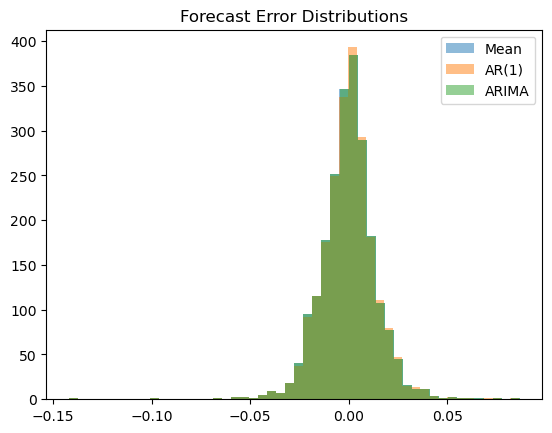

In [30]:
import matplotlib.pyplot as plt

errors = pd.concat(
    [
        (X_test - y_pred_mean).rename("Mean"),
        (y_te - y_pred_ar1).rename("AR(1)"),
        (test["log_return"] - arima_forecast).rename("ARIMA"),
    ],
    axis=1
).dropna()



plt.figure()
for label, err in errors.items():
    plt.hist(err, bins=50, alpha=0.5, label=label)

plt.legend()
plt.title("Forecast Error Distributions")
plt.show()


Interpretation:
Increasing model complexity reduces bias but increases variance, leading to unstable forecasts. In financial time series with low signal-to-noise ratios, this tradeoff severely limits out-of-sample predictability.


Financial markets are adaptive systems. Any predictable structure is quickly arbitraged away, leaving models to fit noise rather than signal.


Conclusion:
Traditional forecasting models fail in financial time series not due to poor implementation, but due to structural limitations imposed by market efficiency and the bias–variance tradeoff.
